# Project: Investigating Kaggle's Soccer Dataset
## Introduction
This notebook is to investigate 3 business related questions from Kaggle's Soccer Dataset.<br>
One of the most impactful factors when it comes to the business of soccer teams is their ability to win matches. Therefore, all the 3 questions in this report are going to be related to that.<br>
<br>
## Package Importing

In [1]:
import sqlite3
import numpy as np
import matplotlib
import scipy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.display import display
pd.options.display.max_columns = None
pd.set_option('display.max_rows', None)

## Data Wrangling
First, we need to establish the connection with the database.

In [3]:
conn = sqlite3.connect("database.sqlite")
c = conn.cursor()

### Data Cleaning
Upon manual inspection, it seems that data cleaning is not needed on this report as the data related to the questions below is clean enough.

## Exploratory Data Analysis
### What team attributes lead to the most victories?
There are 2 important tables, when addressing this question, namely, Match & Team_Attributes. However, the Match table contains the information in terms of the number of goals each team had on each match. However, for the purposes of answering this question, the team name and goal columns are summarized into a single column that reports the name of the winning team (ties are neglected).

In [4]:
# Load all matches from the database
matches = pd.read_sql_query('''
select id, date, match_api_id, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal 
from match''',conn)

# create an empty DataFrame to track wins
filtered_matches = pd.DataFrame(columns=['winner_team','date','id'])

# a variable used as an index/id for filtered_matches dataframe
new_row = 0

# wins tracking is done here...
for row in range(len(matches)):
    if matches['away_team_goal'][row] > matches['home_team_goal'][row]:
        filtered_matches = filtered_matches.append({'winner_team':matches['away_team_api_id'][row],
                                                    'date':matches['date'][row],
                                                    'id':new_row+1},ignore_index=True)
        new_row+=1
    if matches['away_team_goal'][row] < matches['home_team_goal'][row]:
        filtered_matches = filtered_matches.append({'winner_team':matches['home_team_api_id'][row],
                                                    'date':matches['date'][row],
                                                    'id':new_row+1}, ignore_index=True)
        new_row+=1
        
# display result
filtered_matches.head()

,winner_team,date,id
0,8635,2008-08-16 00:00:00,1
1,9991,2008-08-17 00:00:00,2
2,9985,2008-08-16 00:00:00,3
3,9996,2008-08-16 00:00:00,4
4,10001,2008-08-16 00:00:00,5


Then, the winnings are counted and displayed after sorting.

In [5]:
teams_winnings = filtered_matches.groupby(['winner_team'])['date'].count().sort_values(ascending=False)
teams_winnings

winner_team
8634      234
8633      228
9925      218
9823      193
10260     192
9885      189
9772      185
9773      183
8593      181
9931      180
8640      178
8455      176
9847      175
8456      175
9825      170
9906      167
8686      162
9789      157
8636      154
8564      154
9875      153
9748      153
8586      151
8650      150
8639      147
8611      144
9768      144
8592      143
10267     142
10192     142
10229     140
10235     139
8302      139
8673      137
8178      137
8635      136
8535      132
8543      131
10189     127
10264     126
9827      126
2182      124
8342      123
8315      122
9927      122
9853      121
8668      121
10243     120
8485      120
8721      117
9938      115
9956      115
8600      115
10205     112
9851      111
10249     110
9788      109
9991      109
8674      109
10265     108
8548      108
10228     107
9985      106
9864      106
10233     106
9831      106
9908      105
10199     105
8277      105
10179     104
9941    

It seems interesting to have a look at the distribution (histogram) of this metric. However, before we plot the distribution, we need to identify the top tier among those teams. There are multiple ways of selecting those teams. However, I have chosen to choose the top 5% (95-percentile).

In [6]:
# It seems that the cuttoff is 167 (the minimum number of wins to be in the top 5% tier).
# We will highlight this with the green box in the plot
np.percentile(teams_winnings, 95)

167.2999999999999

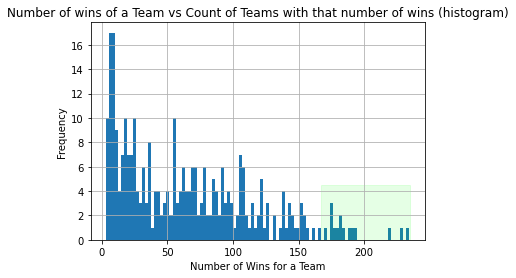

In [7]:
axes = teams_winnings.hist(bins=100);
plt.title('Number of wins of a Team vs Count of Teams with that number of wins (histogram)');
plt.xlabel('Number of Wins for a Team')
plt.ylabel('Frequency')
axes.axvspan(167, 235, ymax=0.25, alpha=0.1, color=(0,1,0));

Interesting enough! All that remains is to know the names of these top teams (highlighted in green). For that, we need to pull the appropriate mapping between team names and their associated ids.

In [8]:
teams = pd.read_sql_query('''
select team_api_id, team_long_name 
from Team''',conn)

In [9]:
# Create a separate dataframe for the top teams
most_winners = teams_winnings[teams_winnings>167].rename('most_winners').to_frame()

# Get the "Number of Wins" column
most_winners = most_winners.reset_index()

# trying to get the ranking of each team
most_winners.index = range(1, 1+len(most_winners.index))
most_winners= most_winners.reset_index()

# Fix columns names which were created from last 3 lines
most_winners.rename(columns={'index':'Rank','most_winners':'Number of Wins'},
                   inplace=True)

# Finaly, getting the teams names
most_winners_named = most_winners.merge(teams, how='left',
                   left_on='winner_team', right_on='team_api_id').drop('team_api_id',axis=1)

# reordering columns for readiblity
cols = most_winners_named.columns.to_list()
cols = cols[:2] + cols[:1:-1]
most_winners_named = most_winners_named[cols]

# Displaying Resulting Dataframe
display(most_winners_named)

,Rank,winner_team,team_long_name,Number of Wins
0,1,8634,FC Barcelona,234
1,2,8633,Real Madrid CF,228
2,3,9925,Celtic,218
3,4,9823,FC Bayern Munich,193
4,5,10260,Manchester United,192
5,6,9885,Juventus,189
6,7,9772,SL Benfica,185
7,8,9773,FC Porto,183
8,9,8593,Ajax,181
9,10,9931,FC Basel,180


As clearly stated above, the team with the greatest number of wins is FC Bercelona followed by Real Madrid CF and then Celtics.

### What are the most contributing-to-wins attributes?
As for the Team_Attributes table, the attributes addressed in this question are only the categorical attributes (contains the word "class" in the column title). This step was done to simplify calculations. Otherwise, the other numeric attributes can be quantized as well. The idea is simply to count the number a given attribute was found in a winning team (winning teams are found above). Since several attributes share some commen values, a simple trick needs to be performed first. Each cell in the Team_Attributes table is going to be transformed as the following: < Column Title > : < Cell Content >, as shown below:

In [10]:
'''This cell exemplifies what the add_column function is aiming to accomplish.
Given a pandas.Series (in this example is the column "A"), we are trying
to produce a series where each element conforms to the following format:
"A:element"
where A is the column title and element is the content of the element from 
column A'''
df = pd.DataFrame(data={'A':['a','b','c','a'],
                       'B':['b','c','d','e']})
display(df)
display(df['A'].name+':'+df['A'])

,A,B
0,a,b
1,b,c
2,c,d
3,a,e


0    A:a
1    A:b
2    A:c
3    A:a
Name: A, dtype: object

This is going to be done by the help of the following function through the DataFrame.apply function

In [11]:
def add_column(mdf):
    '''Takes in a pandas.Series mdf,
    returns another Series where each element is replaced by the following
    from the input series:
    column_title:element_value'''
    return mdf.name + ':' + mdf

In [12]:
df.apply(add_column)

,A,B
0,A:a,B:b
1,A:b,B:c
2,A:c,B:d
3,A:a,B:e


So, going back to our question, the first step is to load the categorical attributes from Team_Attributes table

In [13]:
team_attributes = pd.read_sql_query('''select team_api_id,
buildUpPlaySpeedClass
,buildUpPlayDribblingClass
,buildUpPlayPassingClass
,buildUpPlayPositioningClass
,chanceCreationPassingClass
,chanceCreationCrossingClass
,chanceCreationShootingClass
,chanceCreationPositioningClass
,defencePressureClass
,defenceAggressionClass
,defenceTeamWidthClass
,defenceDefenderLineClass 
from team_attributes''',conn)

Then, keep only the teams which meet the winning criterion specified above (in this case it is redundant as all the teams have won at least 1 match).

In [14]:
winner_team_attributes = team_attributes[team_attributes['team_api_id'].isin(filtered_matches['winner_team'])]
winner_team_attributes.head()

,team_api_id,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass
0,9930,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
1,9930,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
2,9930,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
3,8485,Fast,Little,Long,Organised,Risky,Lots,Lots,Organised,Medium,Double,Wide,Cover
4,8485,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover


The team_api_id column is no longer needed for the attribute counting procedure, so it is deleted.

In [16]:
winner_team_attributes = winner_team_attributes.drop(['team_api_id'],axis=1)
winner_team_attributes.head()

,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass
0,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
1,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
2,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
3,Fast,Little,Long,Organised,Risky,Lots,Lots,Organised,Medium,Double,Wide,Cover
4,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover


The aforementioned transformation is applied.

In [18]:
winner_team_attributes_transformed = winner_team_attributes.apply(add_column)
winner_team_attributes_transformed.head()

,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass
0,buildUpPlaySpeedClass:Balanced,buildUpPlayDribblingClass:Little,buildUpPlayPassingClass:Mixed,buildUpPlayPositioningClass:Organised,chanceCreationPassingClass:Normal,chanceCreationCrossingClass:Normal,chanceCreationShootingClass:Normal,chanceCreationPositioningClass:Organised,defencePressureClass:Medium,defenceAggressionClass:Press,defenceTeamWidthClass:Normal,defenceDefenderLineClass:Cover
1,buildUpPlaySpeedClass:Balanced,buildUpPlayDribblingClass:Normal,buildUpPlayPassingClass:Mixed,buildUpPlayPositioningClass:Organised,chanceCreationPassingClass:Normal,chanceCreationCrossingClass:Normal,chanceCreationShootingClass:Normal,chanceCreationPositioningClass:Organised,defencePressureClass:Medium,defenceAggressionClass:Press,defenceTeamWidthClass:Normal,defenceDefenderLineClass:Cover
2,buildUpPlaySpeedClass:Balanced,buildUpPlayDribblingClass:Normal,buildUpPlayPassingClass:Mixed,buildUpPlayPositioningClass:Organised,chanceCreationPassingClass:Normal,chanceCreationCrossingClass:Normal,chanceCreationShootingClass:Normal,chanceCreationPositioningClass:Organised,defencePressureClass:Medium,defenceAggressionClass:Press,defenceTeamWidthClass:Normal,defenceDefenderLineClass:Cover
3,buildUpPlaySpeedClass:Fast,buildUpPlayDribblingClass:Little,buildUpPlayPassingClass:Long,buildUpPlayPositioningClass:Organised,chanceCreationPassingClass:Risky,chanceCreationCrossingClass:Lots,chanceCreationShootingClass:Lots,chanceCreationPositioningClass:Organised,defencePressureClass:Medium,defenceAggressionClass:Double,defenceTeamWidthClass:Wide,defenceDefenderLineClass:Cover
4,buildUpPlaySpeedClass:Balanced,buildUpPlayDribblingClass:Little,buildUpPlayPassingClass:Mixed,buildUpPlayPositioningClass:Organised,chanceCreationPassingClass:Normal,chanceCreationCrossingClass:Normal,chanceCreationShootingClass:Normal,chanceCreationPositioningClass:Organised,defencePressureClass:Medium,defenceAggressionClass:Press,defenceTeamWidthClass:Normal,defenceDefenderLineClass:Cover


Then, the final step is to count all the occurences of each attribute and display the sorted result.

buildUpPlayPositioningClass:Organised       1386
defenceDefenderLineClass:Cover              1362
chanceCreationPositioningClass:Organised    1309
defenceTeamWidthClass:Normal                1286
defenceAggressionClass:Press                1274
defencePressureClass:Medium                 1243
buildUpPlayPassingClass:Mixed               1236
chanceCreationPassingClass:Normal           1231
chanceCreationShootingClass:Normal          1224
chanceCreationCrossingClass:Normal          1195
buildUpPlaySpeedClass:Balanced              1184
buildUpPlayDribblingClass:Little            1004
buildUpPlayDribblingClass:Normal             433
chanceCreationCrossingClass:Lots             211
chanceCreationShootingClass:Lots             197
buildUpPlaySpeedClass:Fast                   172
chanceCreationPassingClass:Risky             171
defencePressureClass:Deep                    154
chanceCreationPositioningClass:Free Form     149
buildUpPlayPassingClass:Short                128
defenceTeamWidthClas

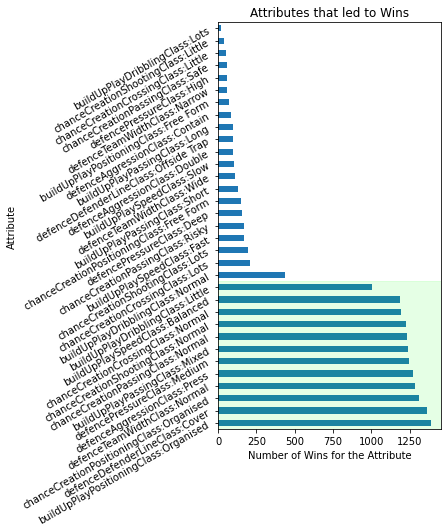

In [19]:
combined = winner_team_attributes_transformed.stack().reset_index(drop = True).value_counts()
display(combined);
axes = combined.plot.barh()
plt.title('Attributes that led to Wins')
plt.xlabel('Number of Wins for the Attribute')
plt.ylabel('Attribute')

plt.setp(axes.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.gcf().canvas.draw()

# the following code snippet is based on this link
# https://stackoverflow.com/questions/44863375/how-to-change-spacing-between-ticks-in-matplotlib
N,m = len(combined.index), 1.8 # num_of_labels, margin in inches
tl = plt.gca().get_yticklabels()
maxsize = max([t.get_window_extent().height for t in tl])
s = maxsize/plt.gcf().dpi*N+2*m
margin = m/plt.gcf().get_size_inches()[1]


plt.gcf().subplots_adjust(bottom=margin, top=1.-margin)
plt.gcf().set_size_inches(plt.gcf().get_size_inches()[1],s)

axes.axhspan(-0.5,11.5, alpha=0.1, color='#00ff00');

One can see from the table above that there is a cutoff below attributes that were counted 1000 times. In other words, these are the attributes that led to the most victories: (sorted)

* buildUpPlayPositioningClass:Organised
* defenceDefenderLineClass:Cover
* chanceCreationPositioningClass:Organised
* defenceTeamWidthClass:Normal
* defenceAggressionClass:Press
* defencePressureClass:Medium
* buildUpPlayPassingClass:Mixed
* chanceCreationPassingClass:Normal
* chanceCreationShootingClass:Normal
* chanceCreationCrossingClass:Normal
* buildUpPlaySpeedClass:Balanced
* buildUpPlayDribblingClass:Little

### Which players had the most penalties?
Penalties can be decisive to certain matches. Threefore, it is interesting to have a look at that.<br> 
This question is quite simpler than the previous one. First, one needs to sum the number of penalties under each player which can be found in the Player_Attributes table. Then, a simple query is done to replace the player IDs with their proper names.

In [20]:
player_penalties = pd.read_sql_query('''
select player.player_name, sum_of_penalties 
from player, 
  (select player_api_id, sum(penalties) as sum_of_penalties 
  from player_attributes 
  group by player_api_id 
  order by sum_of_penalties desc) as sum_table
where player.player_api_id = sum_table.player_api_id''',conn)

This table shows player names and the number of penalties they had. As can be seen the player with most penalties is Alessio Cerci with a total of 4314 penalties, and Timothy van der Meulen is the player with the fewest number of penalties (only 20).

The 5th and 95th percentiles are: 168.0 and 2119.0


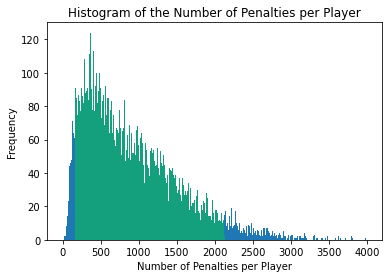

In [21]:
# 5th and 95th percentiles of pentalties
p_5,p_95 = np.percentile(player_penalties.sum_of_penalties, [5,95])
print(f'The 5th and 95th percentiles are: {p_5} and {p_95}')
# Selecting most penalties and adding a column in dataframe for that
most_penalties_filter = lambda x: x if p_5<=x<=p_95 else np.nan
player_penalties['most_penalties'] = player_penalties.sum_of_penalties.apply(most_penalties_filter)

# Plotting both histograms
bins = np.linspace(0,4000,401);

# This particular line is done to align our filtering criterion (5th and 95th percentile with bins)
bins[17], bins[212] = p_5, p_95

plt.hist(player_penalties.sum_of_penalties,bins);
plt.hist(player_penalties.most_penalties,bins, color=(0,1,0), alpha=0.3);
plt.title('Histogram of the Number of Penalties per Player')
plt.xlabel('Number of Penalties per Player')
plt.ylabel('Frequency')
plt.show()

It seems that most of the players had between 170 and 2120 penalties

In [22]:
player_penalties.head()

,player_name,sum_of_penalties,most_penalties
0,Alessio Cerci,4314,NaN
1,Mario Balotelli,4120,NaN
2,Claudio Marchisio,3984,NaN
3,Michael Bradley,3813,NaN
4,Zdravko Kuzmanovic,3799,NaN


while the top three players with most penalties are: Alessio Cerci, Mario Balotelli, Claudio Marchisio

In [23]:
player_penalties.tail()

,player_name,sum_of_penalties,most_penalties
11055,Jakub Divis,45,NaN
11056,Ricardo Campos,39,NaN
11057,Dziugas Bartkus,36,NaN
11058,Sven van der Jeugt,28,NaN
11059,Timothy van der Meulen,20,NaN


## Conclusion
To sum up the result, here is a quick list of the report's observations:
<ol>
    <li> We have discovered that the team with most winnings is FC Bercelona followed by Real Madrid CF and then Celtics. This information could be very useful to advertising companies.<br></li>
<br>
<li> Also, we learned that some of the most attributes for winnings are:

* buildUpPlayPositioningClass:Organised
* defenceDefenderLineClass:Cover
* chanceCreationPositioningClass:Organised

This information can guide team coaches in creating their optimal training routines<br></li>
<li> We also learned that the top three players with most penalties are: 
    
* Alessio Cerci
* Mario Balotelli
* Claudio Marchisio
    
This information can discourage team coaches from allowing these players to play at sensitive times<br></li>

## Limitations
There are several limitations to this work. First, the logic while seemingly sound is a bit simplistic. Also, it could have benefited from a more specific segmentation e.g. per league. Third, it doesn't take into account the time factor where players may change behaviour. Another problem with time is that, for example, when considering the number of penalties question, we ignored the length of time the player has been playing (e.g. 1 year vs 5 years).